## Imports

In [1]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
from bertviz_repo.bertviz import model_view, head_view
import numpy as np
import pickle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import auxLoadFilesAndDictionaries
import pandas as pd
import graficos as graficos

In [2]:
#model to use
#old model
#model_path = 'bert-base-uncased'

CLS_token = "[CLS]"
SEP_token = "[SEP]"

In [3]:
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
config = AutoConfig.from_pretrained('emilyalsentzer/Bio_ClinicalBERT',  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', config=config)

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
#Load cases (patients)
cases = pickle.load( open( "cases_3.bin", "rb" ) )

#Load clinical trials detailed description
dic_detail = pickle.load( open( "dictionarydetailedDocs.bin", "rb" ) )

#A small query
query = cases['20141'].strip()

#Relevant Document for that query
doc_rel= dic_detail['NCT00683813'][:200]
#NonRelevant Document for that query
doc_Nrel=dic_detail['NCT00077948'][:200]

sentence_rel=[query,doc_rel]
sentence_Nrel=[query,doc_Nrel]

In [ ]:
#encode to ids
inputsRelevant = tokenizer.encode_plus(query, doc_rel, return_tensors='pt', add_special_tokens=True)
inputsNonRelevant = tokenizer.encode_plus(query, doc_Nrel, return_tensors='pt', add_special_tokens=True)

print(inputsRelevant)
print(inputsNonRelevant)
#decode back to words
print(tokenizer.decode(inputsRelevant["input_ids"][0].tolist()))
print(tokenizer.decode(inputsNonRelevant["input_ids"][0].tolist()))

In [ ]:
input_idsRelevant = inputsRelevant['input_ids']
input_idsNonRelevant = inputsNonRelevant['input_ids']

#only type tokenized ids of words
print(input_idsRelevant[0].tolist())
print(input_idsNonRelevant[0].tolist())

## Check tokens made with the tokenizer

In [ ]:
#Relevant
input_id_listRelevant = input_idsRelevant[0].tolist() # Batch index 0
tokensRelevant = tokenizer.convert_ids_to_tokens(input_id_listRelevant)
print(tokensRelevant)

#Non Relevant
input_id_listNonRelevant = input_idsNonRelevant[0].tolist() # Batch index 0
tokensNonRelevant = tokenizer.convert_ids_to_tokens(input_id_listNonRelevant)
print(tokensNonRelevant)

In [10]:
#MODEL INFERENCE

#Relevant
outputsRelevant = model(**inputsRelevant)
attentionRelevant = outputsRelevant[-1]

#Non Relevant
outputsNonRelevant = model(**inputsNonRelevant)
attentionNonRelevant = outputsNonRelevant[-1]

#TODO ver o que significam as variaveis
print(len(attentionRelevant[2]))
print(len(attentionRelevant[0][0]))


1
12


In [5]:
def get_word_idx(sent: str, word: str):
    return sent.split(" ").index(word)

def get_hidden_states(encoded, token_ids_word, model, layers):
    """Push input IDs through model. Stack and sum `layers` (last four by default).
        Select only those subword token outputs that belong to our word of interest
        and average them."""
    with torch.no_grad():
        output = model(**encoded)

     # Get all hidden states
    states = output.hidden_states
    # Stack and sum all requested layers
    output = torch.stack([states[i] for i in layers]).sum(0).squeeze()
    # Only select the tokens that constitute the requested word
    word_tokens_output = output[token_ids_word]

    return word_tokens_output.mean(dim=0)


def get_word_vector(sent, idx, tokenizer, model, layers):
    """Get a word vector by first tokenizing the input sentence, getting all token idxs
       that make up the word of interest, and then `get_hidden_states`."""
    encoded = tokenizer.encode_plus(sent, return_tensors="pt")
#     print(encoded)
    # get all token idxs that belong to the word of interest
    token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
#     print(token_ids_word)
    return get_hidden_states(encoded, token_ids_word, model, layers)

In [6]:
def display_pca_scatterplot(words_doc):
    lista_palavras = words_doc.split(' ')
    
    #primeiro layer
    layers=[0]
    plt.figure(figsize=(10,10))

    for i in lista_palavras[:10]:
        idx=get_word_idx(words_doc,i)
        #word embedding has 768 columns (attributes)
        word_embedding=get_word_vector(words_doc,idx,tokenizer,model,layers)
        print(len(word_embedding))
        b=np.array(word_embedding)
        c=np.reshape(b,(1,768))
        X_tsne = TSNE(n_components=2, method='exact')
        feat_tsne=X_tsne.fit_transform(c)
        # aux = zip(lista_palavras[:10], feat_tsne[0])
        # print(aux)
        plt.scatter(feat_tsne[0][0], feat_tsne[0][1], edgecolors='k', c='r')
        plt.text(feat_tsne[0][0], feat_tsne[0][1], i)

            
            
    #ultimo layer        
    layers= [-1]
    for i in lista_palavras[:10]:
        idx=get_word_idx(words_doc,i)
        word_embedding=get_word_vector(words_doc,idx,tokenizer,model,layers)
        b=np.array(word_embedding)
        c=np.reshape(b,(1,768))
        
        X_tsne = TSNE(n_components=2, method='exact')
        feat_tsne=X_tsne.fit_transform(c)

        plt.scatter(feat_tsne[0][0], feat_tsne[0][1], edgecolors='k', c='b')

        plt.text(feat_tsne[0][0], feat_tsne[0][1], i)


768
768
768
768
768
768
768
768
768
768


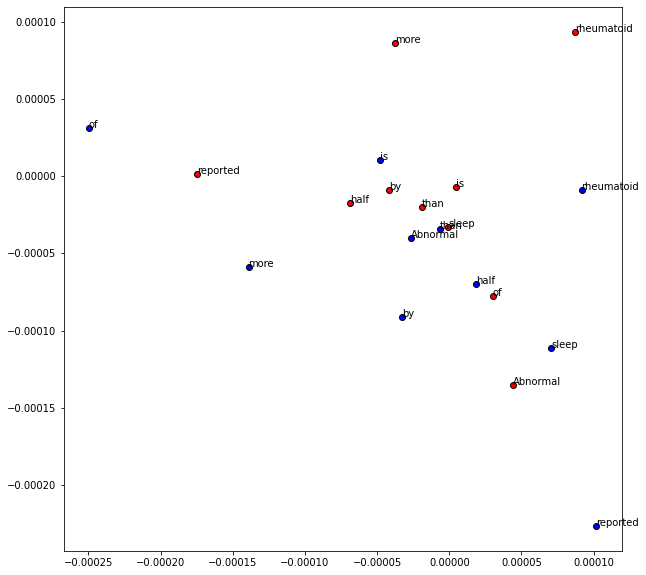

In [13]:
#TODO usar as palavras com mais attention
#falar do que esta a contecer dentro de transformer
display_pca_scatterplot(doc_rel)


# Parte 2 - Contextual embeddings visualization
# Extract Token embeddings

In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

    #Relevant

    #utilizar uma parte do documento em vez de todo
call_html()
head_view(attentionRelevant, tokensRelevant)
model_view(attentionRelevant, tokensRelevant)

#Non Relevant
call_html()
head_view(attentionNonRelevant, tokensNonRelevant)
model_view(attentionNonRelevant, tokensNonRelevant)

## Neural ranking

In [7]:
def convert_to_bert_input(sentences, max_seq_length, tokenizer, add_cls, return_tensors="pt"):

    # The convention in BERT is:
    # (a) For sequence pairs:
    #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
    #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
    # (b) For single sequences:
    #  tokens:   [CLS] the dog is hairy . [SEP]
    #  type_ids: 0   0   0   0  0     0 0
    #
    # Where "type_ids" are used to indicate whether this is the first
    # sequence or the second sequence. The embedding vectors for `type=0` and
    # `type=1` were learned during pre-training and are added to the wordpiece
    # embedding vector (and position vector). 
    #
    # For classification tasks, the first vector (corresponding to [CLS]) is
    # used as as the "sentence vector".
    
    # Tokenize both sentences
    sentences_tokens = [tokenizer.tokenize(s + SEP_token) for s in sentences]
    
    # Combine sentences tokens on a single list
    tokens = sum(sentences_tokens, [])
    
    if add_cls:
        tokens = [CLS_token] + tokens

    # Create Token type ids tensors
    token_type_ids = [[i]*len(s) for i, s in enumerate(sentences_tokens)] # Acount for the SEP token we've just added
    token_type_ids = [0] + sum(token_type_ids, []) # CLS + The whole token_type_ids flattened

    # Remove tokens if max_seq_length is exceeded
    # Account for [CLS] and [SEP] with "- 3"
    if len(tokens) > max_seq_length - 3:
        tokens = tokens[:max_seq_length - 4] + [tokens[-1]] # keep SEP token
        token_type_ids = token_type_ids[:max_seq_length - 3]

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
     # Create Attention mask tensor -> Which tokens should BERT consider
    attention_mask = [1]*len(tokens)
    
    if return_tensors == "pt":
        input_ids = torch.tensor([input_ids], dtype=torch.long)
        token_type_ids = torch.tensor([token_type_ids], dtype=torch.long)
        attention_mask = torch.tensor([attention_mask], dtype=torch.long)
    
    data = {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_mask
    }

    return data

## Query-Document relevant Heat-Map

In [ ]:
#TODO NAO QUEREMOS O DA PRIMEIRA LAYER E O DA SEGUNDA, QUEREMOS E O INPUT E O OUTPUT DA PRIMEIRA

sentences = [query, doc_rel]
inputs_query_passages = convert_to_bert_input(sentences=sentences, max_seq_length=512, tokenizer=tokenizer, add_cls=True)
#print(inputs_query_passages)
decoded_input_qa = tokenizer.decode(inputs_query_passages["input_ids"][0])
# print(decoded_input_qa)
outputs_qa = model(**inputs_query_passages)
# print(outputs_qa)

tokenizedSentence = decoded_input_qa
lista_palavras = tokenizedSentence.split(' ')
# newlista = []
# for i in lista_palavras:
#     if i != "" and len(i) >= 2:
#         newlista.append(i)
# print(newlista)
# lista_palavras = newlista

inputEmbeddings = []
for token in lista_palavras:
    idx=get_word_idx(tokenizedSentence,token)
    word_embedding=outputs_qa[0][0][idx]
    word_embedding=word_embedding.detach().numpy()
    b=np.array(word_embedding)
    c=np.reshape(b,(1,768))
    inputEmbeddings.append(c)
    #print(token)

outputEmbeddings = []
layers=[0]
for token in lista_palavras:
    idx=get_word_idx(tokenizedSentence,token)
    word_embedding=get_word_vector(tokenizedSentence,idx,tokenizer,model,layers)
    b=np.array(word_embedding)
    c=np.reshape(b,(1,768))
    outputEmbeddings.append(c)

newInputEmbeddings = []
for i in inputEmbeddings:
    newInputEmbeddings.append(i[0])

newOutputEmbeddings = []
for i in outputEmbeddings:
    newOutputEmbeddings.append(i[0])
    


# Declaring rows
N = len(newInputEmbeddings)
# Declaring columns
M = len(newOutputEmbeddings)
# using list comprehension 
# to initializing matrix
matrixCorr = [ [ 0 for i in range(M) ] for j in range(N) ]

import math

for i in range(0, len(newInputEmbeddings)):
    for j in range(0, len(newOutputEmbeddings)):
        produto = np.dot(newInputEmbeddings[i], newOutputEmbeddings[j])
        print(produto)
        #TODO da nan no calculo dos ultimos output embeddings nao sei pq (estou a substituir os nans por 0)
        if math.isnan(produto):
            print("======")
            print(newInputEmbeddings[i])
            print(newOutputEmbeddings[j])
            produto = 0
            print("======")

        matrixCorr[i][j] = produto

# matrizMult = np.dot(newInputEmbeddings,newOutputEmbeddings)
print(np.shape(matrixCorr))
#nr linhas = nrLinhas primeira
#nr colunas = nrColunas segunda


import seaborn as sns
import pandas as pd

x_axis_labels = lista_palavras
y_axis_labels = lista_palavras
sns.heatmap(matrixCorr, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

## Query-Document NON-Relevant Heat-Map

In [ ]:
sentences = [query, doc_Nrel]
inputs_query_passages = convert_to_bert_input(sentences=sentences, max_seq_length=512, tokenizer=tokenizer, add_cls=True)
#print(inputs_query_passages)
decoded_input_qa = tokenizer.decode(inputs_query_passages["input_ids"][0])
# print(decoded_input_qa)
outputs_qa = model(**inputs_query_passages)
# print(outputs_qa)

tokenizedSentence = decoded_input_qa
lista_palavras = tokenizedSentence.split(' ')
# newlista = []
# for i in lista_palavras:
#     if i != "" and len(i) >= 2:
#         newlista.append(i)
# print(newlista)
# lista_palavras = newlista

inputEmbeddings = []
for token in lista_palavras:
    idx=get_word_idx(tokenizedSentence,token)
    word_embedding=outputs_qa[0][0][idx]
    word_embedding=word_embedding.detach().numpy()
    b=np.array(word_embedding)
    c=np.reshape(b,(1,768))
    inputEmbeddings.append(c)
    #print(token)

outputEmbeddings = []
layers=[0]
for token in lista_palavras:
    idx=get_word_idx(tokenizedSentence,token)
    word_embedding=get_word_vector(tokenizedSentence,idx,tokenizer,model,layers)
    b=np.array(word_embedding)
    c=np.reshape(b,(1,768))
    outputEmbeddings.append(c)

newInputEmbeddings = []
for i in inputEmbeddings:
    newInputEmbeddings.append(i[0])

newOutputEmbeddings = []
for i in outputEmbeddings:
    newOutputEmbeddings.append(i[0])
    


# Declaring rows
N = len(newInputEmbeddings)
# Declaring columns
M = len(newOutputEmbeddings)
# using list comprehension 
# to initializing matrix
matrixCorr = [ [ 0 for i in range(M) ] for j in range(N) ]

import math

for i in range(0, len(newInputEmbeddings)):
    for j in range(0, len(newOutputEmbeddings)):
        produto = np.dot(newInputEmbeddings[i], newOutputEmbeddings[j])
        print(produto)
        #TODO da nan no calculo dos ultimos output embeddings nao sei pq (estou a substituir os nans por 0)
        if math.isnan(produto):
            print("======")
            print(newInputEmbeddings[i])
            print(newOutputEmbeddings[j])
            produto = 0
            print("======")

        matrixCorr[i][j] = produto

# matrizMult = np.dot(newInputEmbeddings,newOutputEmbeddings)
print(np.shape(matrixCorr))
#nr linhas = nrLinhas primeira
#nr colunas = nrColunas segunda


import seaborn as sns
import pandas as pd

x_axis_labels = lista_palavras
y_axis_labels = lista_palavras
sns.heatmap(matrixCorr, xticklabels=x_axis_labels, yticklabels=y_axis_labels)



In [8]:
from sklearn.model_selection import train_test_split

#todas combinacoes do qrels
dicionarioPlotFinal = pickle.load( open( "dicionarioPlotFinal.bin", "rb" ) )
print(len(dicionarioPlotFinal))


test_query= set()
for i in np.array(list(dicionarioPlotFinal.keys())):
    test_query.add(i[0])

class_train, class_test = train_test_split(np.array(list(test_query)),test_size = 0.20, random_state = 12)
print(len(class_train))
print(len(class_test))



matriz_keys_test=[]
matriz_feat_test=[]
matriz_feat_train=[]
matriz_keys_train=[]

for k,v in dicionarioPlotFinal.items():
    if k[0] in class_test:
        matriz_keys_test.append(k)
        matriz_feat_test.append(v)
        #teste
    else:
        #treino
        matriz_feat_train.append(v)
        matriz_keys_train.append(k)
        
# print(matriz_keys_train)
allaux = set()
for i in matriz_keys_train:
    allaux.add(i[0])
print(len(allaux))
#idquery, iddoc = 768 atributos

3870
47
12
47


## TREINO - calcular embeddings para os relevantes e nao relevantes

In [16]:
#TODO standardizar e normalizar os dados

#SO TREINO
#ter uma lista de tuplos (query, doc) so com relevantes
#so queremos as queries que tem detailed description - dic_detail

allRelevants = []
for i in matriz_keys_train:
    for k,v in dic_detail.items():
        if ((i[2] == '1') or (i[2] == '2')) and i[1] == k:
            allRelevants.append((i[0], i[1], 1))
print(len(allRelevants))

#criar tuplo (query,doc), só os doc que tem detailed discption
query_doc_rel=[]
for k,v in dic_detail.items():
    for i in allRelevants:
        if k==i[1]:
            query_doc_rel.append((i[0],i[1],i[-1]))


allNonRelevants = []
for i in matriz_keys_train:
    for k,v in dic_detail.items():
        if (i[2] == '0') and (i[1] == k):
            allNonRelevants.append((i[0], i[1], 0))
print(len(allNonRelevants))


query_doc_nrel=[]
for k,v in dic_detail.items():
    for i in allNonRelevants:
        if k==i[1]:
            query_doc_nrel.append((i[0],i[1],i[-1]))

# allQueryDocRelevant = [()]####
# #todos os embeddings do cls (primeiro token) das queries-doc relevantes
# #chave = (query, doc, score?? para calcular melhor c com crossv)
# #valor = array de 768 atributos
allRelevantEmbeddings = dict()
#id query - id doc relevante
for (queryID, documentoID,rel) in query_doc_rel:
    query = cases[queryID]
    doc_rel = dic_detail[documentoID]
    doc_rel=doc_rel[:200]
    

    sentence_rel=[query,doc_rel]
    inputs_query_passagesRelevant = convert_to_bert_input(sentences=sentence_rel, max_seq_length=512, tokenizer=tokenizer, add_cls=True)
    decoded_input_qaRelevant = tokenizer.decode(inputs_query_passagesRelevant["input_ids"][0])

    outputs_qaRelevant = model(**inputs_query_passagesRelevant)
    #cls embedding (first token) = has 768 features
    # print(outputs_qaRelevant[0][0][0])
    embeddingRelevante = outputs_qaRelevant[0][0][0]
    embeddingRelevante = embeddingRelevante.detach().numpy()
    allRelevantEmbeddings[(queryID, documentoID, rel)] = embeddingRelevante
    


allNonRelevantEmbeddings = dict()
#query - doc nao relevante
for (queryID, documentoID,rel) in query_doc_nrel:
    queryText = cases[queryID]
    doc_NrelText = dic_detail[documentoID]
    doc_NrelText=doc_NrelText[:200]
    
    sentence_Nrel=[query,doc_Nrel]
    inputs_query_passagesNonRelevant = convert_to_bert_input(sentences=sentence_Nrel, max_seq_length=512, tokenizer=tokenizer, add_cls=True)
    decoded_input_qaNonRelevant = tokenizer.decode(inputs_query_passagesNonRelevant["input_ids"][0])

    outputs_qaNonRelevant = model(**inputs_query_passagesNonRelevant)
    embeddingNaoRelevante = outputs_qaNonRelevant[0][0][0]
    embeddingNaoRelevante = embeddingNaoRelevante.detach().numpy()

    allNonRelevantEmbeddings[(queryID, documentoID, rel)] = embeddingNaoRelevante
    

#juntar tudo e fazer shuffle
# allNonRelevantEmbeddings
# allRelevantEmbeddings


import random
dictionaryAllEmbeddings = dict(list(allNonRelevantEmbeddings.items()) + list(allRelevantEmbeddings.items()))
#shuffle dictionary

shuffled = list(dictionaryAllEmbeddings.items())
random.shuffle(shuffled)
shuffledDictionary = dict(shuffled)

#valores=[]
# for i in shuffledDictionary.values():
#     valores.append(i)

# media=np.mean(valores, axis=1)
# sd=np.std(valores)
# for k,i in shuffledDictionary.items():
#     shuffledDictionary[k]=(i-media)/sd

# calcular os coeficientes com a log reg (com o melhor c)
###

589
1535


In [20]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
# valores=[]
# for i in shuffledDictionary.values():
#     valores.append(i)
# valores=np.array(valores)
# scaler = MinMaxScaler()
# scaler.fit(valores)
# # media=np.mean(valores, axis=1)
# # sd=np.std(valores)
# for k,i in shuffledDictionary.items():
#     i=i.reshape(1,768)
#     shuffledDictionary[k]=scaler.transform(i)
class_train

[0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,


## Calcular o melhor C

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

kf = StratifiedKFold(n_splits=5)

class_train = []
feat_train = []
for k,v in shuffledDictionary.items():
    class_train.append(k[-1])
    feat_train.append(v)


def calc_fold_LR(X,Y, train_ix,valid_ix,c):
    Log_regression1 = LogisticRegression(C=c, max_iter=10000)
    X=np.array(X)
    Y=np.array(Y)
    Log_regression1.fit(X[train_ix],Y[train_ix])
    t_e=1-Log_regression1.score(X[train_ix],Y[train_ix]) 
    v_e=1-Log_regression1.score(X[valid_ix],Y[valid_ix]) 
    return t_e, v_e

range_c = np.arange(0.1,1,0.1)
best_error = 10000
best_c = 0
train_error_list=[]
valid_error_list=[]
for c in range_c:
    tr_err = va_err = 0
    for tr_ix,va_ix in kf.split(class_train,class_train): 
        r,v = calc_fold_LR(feat_train,class_train,tr_ix,va_ix, c)
        tr_err += r #erro de treino
        va_err += v #erro de validacao, para escolher a melhor hipotese
    
    tr_err_mean =tr_err/5
    va_err_mean =va_err/5
    train_error_list.append(tr_err_mean)
    valid_error_list.append(va_err_mean)
    
    if(best_error> va_err_mean):
        best_error=va_err_mean
        best_c=c
print(best_c)

0.1


## Descobrir coeficientes com os dados de treino

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold


#tentar fazer cross validation para calcular o c caso tenhamos valores suficientes
Log_regression1=LogisticRegression(max_iter = 10000, random_state=0, C = best_c)
#separar feats e classes de treino

Log_regression1.fit(feat_train,class_train)
coeficientes = Log_regression1.coef_
print(coeficientes[0])

[-3.02949192e-02  8.26387563e-02  1.91650795e-02 -1.21867283e-02
 -7.96844604e-02  1.76196532e-01 -5.75108056e-02 -9.39572742e-02
 -1.66782063e-01  2.53697082e-02 -3.87178814e-02 -2.85181891e-02
  9.18828947e-02 -6.88449274e-02  4.76287783e-02 -9.64651667e-03
  5.21449943e-02  4.66514260e-02 -3.53846009e-02  1.69194175e-01
 -7.51166526e-03 -1.25315714e-01 -3.80985870e-02 -1.48720610e-01
 -2.47567855e-03  5.75536754e-02  5.82423838e-02  4.29172793e-02
 -8.92241968e-02  6.83135590e-02 -3.85551226e-03  8.79958504e-03
  1.10731578e-01 -4.88108797e-02  6.73615954e-02  9.29755825e-02
 -4.75966880e-02 -1.03433674e-02  1.88181305e-02  2.78499556e-02
  5.65107116e-02 -5.40971560e-02  2.25113753e-02  1.02598614e-01
  1.30455083e-01  4.06989874e-02 -4.82161146e-02 -1.13084988e-01
 -4.44855848e-02  9.35578706e-02  9.06445531e-03 -4.75410131e-02
  5.56611168e-03 -6.76071646e-03 -2.97219464e-02  4.74817104e-02
  8.74256800e-02 -8.65614660e-02 -1.20242995e-01  6.55000019e-02
 -9.68226362e-04  2.28736

In [13]:
dictionaryGendersQueries, dictionaryAgesQueries, vectorizerQueries, YQueries, eval = auxLoadFilesAndDictionaries.loadAux() 
docsGender, ids, docMaxAge, docMinAge, dictionaryGendersDocs, dictionaryAgesDocs = auxLoadFilesAndDictionaries.loadFiles()

Nr de pacientes (queries): 60


In [22]:
# Calcular embeddings para dados de teste

dicionario_teste = dict()

allRelevantsTest = []
for i in matriz_keys_test:
    for k,v in dic_detail.items():
        if ((i[2] == '1') or (i[2] == '2')) and i[1] == k:
            allRelevantsTest.append((i[0], i[1], 1))
            
print(len(allRelevantsTest))



allNonRelevantsTest = []
for i in matriz_keys_test:
    for k,v in dic_detail.items():
        if (i[2] == '0') and (i[1] == k):
            allNonRelevantsTest.append((i[0], i[1], 0))
print(len(allNonRelevantsTest))

#calcular o embedding e preencgher o dicionario
#################################################################

allRelevantEmbeddingsTest = dict()
#id query - id doc relevante
for (queryID, documentoID, rel) in allRelevantsTest:
    query = cases[queryID]
    doc_rel = dic_detail[documentoID]
    doc_rel=doc_rel[:100]

    sentence_rel=[query,doc_rel]
    inputs_query_passagesRelevant = convert_to_bert_input(sentences=sentence_rel, max_seq_length=512, tokenizer=tokenizer, add_cls=True)
    decoded_input_qaRelevant = tokenizer.decode(inputs_query_passagesRelevant["input_ids"][0])

    outputs_qaRelevant = model(**inputs_query_passagesRelevant)
    #cls embedding (first token) = has 768 features
    # print(outputs_qaRelevant[0][0][0])
    embeddingRelevante = outputs_qaRelevant[0][0][0]
    embeddingRelevante = embeddingRelevante.detach().numpy()
    allRelevantEmbeddingsTest[(queryID, documentoID, rel)] = embeddingRelevante
    


allNonRelevantEmbeddingsTest = dict()
#query - doc nao relevante
for (queryID, documentoID, rel) in allNonRelevantsTest:
    queryText = cases[queryID]
    doc_NrelText = dic_detail[documentoID]
    doc_NrelText=doc_NrelText[:100]
    sentence_Nrel=[query,doc_Nrel]
    inputs_query_passagesNonRelevant = convert_to_bert_input(sentences=sentence_Nrel, max_seq_length=512, tokenizer=tokenizer, add_cls=True)
    decoded_input_qaNonRelevant = tokenizer.decode(inputs_query_passagesNonRelevant["input_ids"][0])

    outputs_qaNonRelevant = model(**inputs_query_passagesNonRelevant)
    embeddingNaoRelevante = outputs_qaNonRelevant[0][0][0]
    embeddingNaoRelevante = embeddingNaoRelevante.detach().numpy()

    allNonRelevantEmbeddingsTest[(queryID, documentoID, rel)] = embeddingNaoRelevante
    

#juntar tudo e fazer shuffle
# allNonRelevantEmbeddings
# allRelevantEmbeddings


import random
dictionaryAllEmbeddingsTest = dict(list(allNonRelevantEmbeddingsTest.items()) + list(allRelevantEmbeddingsTest.items()))
#shuffle dictionary

shuffledTest = list(dictionaryAllEmbeddingsTest.items())
random.shuffle(shuffledTest)
shuffledDictionaryTest = dict(shuffledTest)

print(len(shuffledDictionaryTest))

211
388
599


In [32]:
print(len(shuffledDictionaryTest))
print(len(docsGender), len(ids), len(docMaxAge), len(docMinAge), len(dictionaryGendersDocs), len(dictionaryAgesDocs))
print(len(dictionaryGendersQueries), len(dictionaryAgesQueries))
print(len(class_test))

516
3626 3626 3626 3626 3626 3626
60 60
12


In [15]:
shuffledDictionaryTest

NameError: name 'shuffledDictionaryTest' is not defined

In [ ]:
#queryID docID 668 features

dicQueryDocs = dict()
listaDocsFinal = []
#scores para cada um dos triplos (qID, docID, score) 
#queremos (qID) => [docsIDs ordenados]

allP10s,allMrr, allNdcg5, allAp, allRecall = ([] for i in range(5))
avg_precision_11pointLETORUni = np.zeros(11)
dictCaseIDP10 = dict()
dictCaseAP = dict()
#adicionar os (docID, scores) para cada query
for i in class_test:
    docScores = []
    docIds = []
    #Para cada triplo para fazer para cada doc com essa query
    for k,v in shuffledDictionaryTest.items():
        if k[0] == i:
            #verificar se é do mm sexo ou da para os dois
            if dictionaryGendersQueries[i] == dictionaryGendersDocs[k[1]] or dictionaryGendersDocs[k[1]] == "Both":
                #verificar se idades batem certo:
                #idade da query tem de ser maior ou igual a min age e menor ou igual a max age
                ageQuery = int(dictionaryAgesQueries[i].replace(" Years", ""))
                
                ## MinAge
                minAgeStudy = dictionaryAgesDocs[k[1]][0].replace(" Years", "").replace(" Year", "").replace("N/A", "-1")
                if len(minAgeStudy.split(" ")) > 1:
                    if (minAgeStudy.split(" ")[1] == "Months") or (minAgeStudy.split(" ")[1] == "Month") :
                        #Caso tenha idade minima com meses
                        minAgeStudy = int(minAgeStudy.split(" ")[0])/12

                    elif (minAgeStudy.split(" ")[1] == "Weeks") or (minAgeStudy.split(" ")[1] == "Week") :
                        minAgeStudy = float(minAgeStudy.split(" ")[0]) * 0.019165

                    elif (minAgeStudy.split(" ")[1] == "Days") or (minAgeStudy.split(" ")[1] == "Day"):
                        minAgeStudy = float(int(minAgeStudy.split(" ")[0]) * 0.002738)
                    elif (minAgeStudy.split(" ")[1] == "Hours") or (minAgeStudy.split(" ")[1] == "Hour"):
                        minAgeStudy = float(int(minAgeStudy.split(" ")[0]) * 0.000114)
                minAgeStudy = float(minAgeStudy)

                ## MaxAge
                maxAgeStudy = dictionaryAgesDocs[k[1]][1].replace(" Years", "").replace(" Year", "").replace("N/A", "-1")
                if len(maxAgeStudy.split(" ")) > 1:
                    if (maxAgeStudy.split(" ")[1] == "Months") or (maxAgeStudy.split(" ")[1] == "Month"):
                        #Caso tenha idade minima com meses
                        maxAgeStudy = int(maxAgeStudy.split(" ")[0])/12
                    elif (maxAgeStudy.split(" ")[1] == "Weeks") or (maxAgeStudy.split(" ")[1] == "Week") :
                        maxAgeStudy = float(maxAgeStudy.split(" ")[0]) * 0.019165
                    elif (maxAgeStudy.split(" ")[1] == "Days") or (maxAgeStudy.split(" ")[1] == "Day"):
                        maxAgeStudy = float(int(maxAgeStudy.split(" ")[0]) * 0.002738)
                    elif (maxAgeStudy.split(" ")[1] == "Hours") or (maxAgeStudy.split(" ")[1] == "Hour"):
                        maxAgeStudy = float(int(maxAgeStudy.split(" ")[0]) * 0.000114)
            
                maxAgeStudy = float(maxAgeStudy)

                if (ageQuery >= minAgeStudy and ageQuery <= maxAgeStudy) or (minAgeStudy == -1 and ageQuery <= maxAgeStudy) or (maxAgeStudy == -1 and ageQuery >= minAgeStudy):
                    
                    #TODO usar com mulktiplicacao de matizes
                    contaComCoeficientes = 0
                    j = 0
                    for coef in coeficientes:
                        contaComCoeficientes += coef[j]*v[j]
                        j +=1
                    docScores.append(contaComCoeficientes)
                    docIds.append(k[1])
                            
                    #results_ord = results.sort_values(by=['score'], ascending = False)
                    #listaDocscores.append(results_ord)
                    #query ainda nao foi posta
                    if k[0] not in dicQueryDocs:  
                        
                        contaComCoeficientes = 0
                        j = 0
                        for coef in coeficientes:
                            contaComCoeficientes += coef[j]*v[j]
                            j +=1
                        docScores.append(contaComCoeficientes)
                        docIds.append(k[1])
                        

                        #dataframe
                        dicQueryDocs[i]= [(k[1], contaComCoeficientes)]
                    
                    #query ja esta no dicionario
                    else:
                        
                        contaComCoeficientes = 0
                        j = 0
                        for coef in coeficientes:
                            contaComCoeficientes += coef[j]*v[j]
                            j +=1
                        docScores.append(contaComCoeficientes)
                        docIds.append(k[1])

                        dicQueryDocs[i].append((k[1], contaComCoeficientes))
                else:
                    pass
            else:
                pass
        else:
            pass

    #repetir id da query
    caseIdRep = [i] * len(docIds)
    results = pd.DataFrame(list(zip(caseIdRep, docIds, docScores)), columns = ['caseid', '_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)
    listaDocsFinal.append(results_ord)   
    
    [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, i)
    #Para fazer as medias dos prints
    allP10s.append(p10)
    allMrr.append(mrr)
    allNdcg5.append(ndcg5)
    allAp.append(ap)
    allRecall.append(recall)

    #Para fazer plot de P10-CaseId e AP-Case id (os pacientes com mais matches)
    dictCaseIDP10[i] = p10
    dictCaseAP[i] = ap

    [precision_11pointLETORUni, recall_11pointLETORUni, total_relv_ret] = eval.evalPR(results_ord, i)
    if (np.shape(recall_11pointLETORUni) != (0,)):
        avg_precision_11pointLETORUni = avg_precision_11pointLETORUni + precision_11pointLETORUni


averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall = graficos.calculateAvgMetrics(allP10s, allMrr, allNdcg5, allAp, len(class_test), allRecall)
graficos.printMetrics(averageAllP10s, averageAllMrr, averageNdcg5, averageAp, averageRecall)
graficos.makePrecisionRecall(recall_11pointLETORUni, avg_precision_11pointLETORUni, len(class_test), None, "BERT: Precision-Recall w/ Ngram: 1")
graficos.makeIDP10Graphic(dictCaseIDP10, "BERT: P10/CaseID w/ Ngram: 1", 12)

